## Output Probabilities for all subjects and ROC curve inputs for some kind of statistical anlysis of ROC curves

From request [ROC Output and Probabilities](https://trello.com/c/JcZRCXte)

## Imports and Function Definitions

In [4]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import itertools

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_recall_fscore_support, roc_curve, make_scorer, accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold, train_test_split, LeaveOneOut, GridSearchCV, cross_validate
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

def plot_confusion_matrix(cm, classes=[0,1],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def grid_search_optimization(model, tuned_parameters, X, y, Xh, yh, cv=5, scoring='accuracy', verbose=False):
    print("# Tuning hyper-parameters for %s" %scoring)
    print()

    clf = GridSearchCV(model, tuned_parameters, cv=cv, n_jobs = -1, scoring=scoring, verbose=1)
    clf.fit(X, y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    if verbose:
        print("Grid scores on development set:")
        print()
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        print()

    print("Detailed classification report (holdout):")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = yh, clf.predict(Xh)
    print(classification_report(y_true, y_pred))
    print()
    plot_confusion_matrix(confusion_matrix(y_true, y_pred)) 
    print()
    get_metrics(clf.best_estimator_, Xh, yh)
    
    print("TRAINNG PROBABILITIES")
    for a,b in zip(y, clf.predict_proba(X)[:,1]):
        print(a,b)
    
    return clf

def group_classes(data, grouping):
        classes_to_keep = grouping.keys()
        data_to_keep = data.loc[data['GroupID'].isin(classes_to_keep)]
        classes_to_change = {k:grouping[k] for k in classes_to_keep if k!= grouping[k]}
        return data_to_keep.replace(classes_to_change)
    
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
     plt.show()
        
def print_feature_importance(feature_names, coefs):
    assert len(feature_names) == len(coefs), "Arrays have difference lengths. Something went wrong"
    for feature, coef in zip(feature_names, coefs):
        print("%s\t%s" %(feature, coef))
        
# AKA True Negative Rate
def specificity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[0,:].sum()

def negative_predictive_value(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0] / cm[:,0].sum()

def get_weighted_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0,0]
    tp = cm[1,1]
    fp = cm[0,1]
    fn = cm[1,0]
    
    tnw = tn / (tn + fp)
    tpw = tp / (tp + fn)
    fpw = fp / (tn + fp)
    fnw = fn / (tp + fn)
    
    return tpw, fpw, fnw, tnw

def weighted_accuracy(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return (tpw + tnw) / (tpw + fpw + fnw + tnw)
    
def weighted_sensitivity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tpw / (tpw + fnw)
    
def weighted_specificity(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)

    return tnw / (tnw + fpw)
    
def weighted_ppv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tpw / (tpw + fpw)

def weighted_npv(y_true, y_pred):
    tpw, fpw, fnw, tnw = get_weighted_confusion_matrix(y_true, y_pred)
    
    return tnw / (tnw + fnw)

def plot_roc(model, X_test, Y_test):
    y_true, y_pred = Y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))

    y_pred_prob = model.predict_proba(X_test)[:,1]

    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)

    print("TESTING PROBABILITIES")
    for a,b in zip(Y_test,y_pred_prob):
        print(a,b)
    
    plt.plot([0,1],[0,1], 'k--')
    plt.plot(fpr, tpr, label='Linear SVC')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Linear SVC ROC Curve')
    plt.show()
    
    for a,b in zip(fpr, tpr):
        print(a,b)
    
def get_metrics(model, X, y):
    for metric in _scoring_list:
        score = _scoring_list[metric](model, X, y)
        print("%s\t%s" %(metric, score))

## Define classifier, pipeline and constants

In [5]:
param_grid = {
    "classifier__C": np.logspace(-5, 2, 20),
#     "PCA__n_components": range(1,113,10),
#     "fss__k": range(1,115,3),
},

clf = Pipeline([
#     ('Norm', Normalizer()),\n",
#     ("Oversample", RandomOverSampler()),
#     ('PCA', PCA()),
    ('Scaler', StandardScaler()),
#     ('fss',SelectKBest()),
    ('classifier', SVC(kernel='linear', class_weight='balanced', probability=True))
])

_cv=5
_test_size=0.20
_scoring_list={
    'recall':make_scorer(recall_score),
    'precision':make_scorer(precision_score),
    'auc':make_scorer(roc_auc_score),
    'specificity':make_scorer(specificity),
    'npv':make_scorer(negative_predictive_value),
    'accuracy':make_scorer(accuracy_score),
    'weighted_sensitivity':make_scorer(weighted_sensitivity),
    'weighted_ppv':make_scorer(weighted_ppv),
    'weighted_specificity':make_scorer(weighted_specificity),
    'weighted_npv':make_scorer(weighted_npv),
    'weighted_accuracy':make_scorer(weighted_accuracy)
}

_scoring='f1_micro'
_data = pd.read_excel('Data_no_UM.xlsx')
_data = _data[['GroupID', 'Age', 'Sex', 'UPDRS']]
_random_seed = 55

## 1. Control vs. PD/MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.7s finished


Best parameters set found on development set:

{'classifier__C': 0.6158482110660255}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.78      1.00      0.88        36
          1       1.00      0.92      0.96       124

avg / total       0.95      0.94      0.94       160


Confusion matrix, without normalization
[[ 36   0]
 [ 10 114]]

recall	0.91935483871
precision	1.0
auc	0.959677419355
specificity	1.0
npv	0.782608695652
accuracy	0.9375
weighted_sensitivity	0.91935483871
weighted_ppv	1.0
weighted_specificity	1.0
weighted_npv	0.925373134328
weighted_accuracy	0.959677419355
TRAINNG PROBABILITIES
1 0.999999998853
1 0.999999999077
0 0.0653177766538
1 0.999999493742
0 0.338179299619
1 0.999996996044
1 0.989646128049
1 0.999987139824
1 0.950415697356
0 0.0596715126717
1 0.999994058073
1 0.999999999913
1 0.780162833948


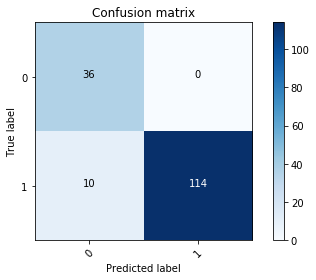

In [6]:
# Get the data
data1 = group_classes(_data, {0:0, 1:1, 2:1, 3:1})

y1 = data1['GroupID']
X1 = data1.drop(['GroupID'], axis=1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, y1, test_size=_test_size, random_state=_random_seed)

best1 = grid_search_optimization(clf, param_grid, X_train1, Y_train1, X_test1, Y_test1, cv=_cv, scoring=_scoring)

In [7]:
scores = cross_validate(best1.best_estimator_, X_train1, Y_train1, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0150993347168	0.00136092477152
score_time	0.0198059558868	0.00609089742391
test_recall	0.957446808511	0.022315081876
train_recall	0.952659574468	0.00701643933951
test_precision	0.98678226869	0.00835876023899
train_precision	0.98676887557	0.00210855602414
test_auc	0.960719839193	0.0202494733391
train_auc	0.958261890219	0.0059696050266
test_specificity	0.963992869875	0.0223037323631
train_specificity	0.963864205969	0.00557836951634
test_npv	0.89117790706	0.0509187800815
train_npv	0.878153613466	0.016567544068
test_accuracy	0.959128937008	0.0207512085937
train_accuracy	0.955582971087	0.00640056054086
test_weighted_sensitivity	0.957446808511	0.022315081876
train_weighted_sensitivity	0.952659574468	0.00701643933951
test_weighted_ppv	0.963921220428	0.0224721295305
train_weighted_ppv	0.963454120986	0.00563000171444
test_weighted_specificity	0.963992869875	0.0223037323631
train_weighted_specificity	0.963864205969	0.00557836951634
test_weighted_npv	0.95788202455	0.021610887229
train_

In [8]:
model = best1.best_estimator_.named_steps['classifier']
feature_names = data1.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.236455600934
Sex	-0.0707288767064
UPDRS	3.3012960882


             precision    recall  f1-score   support

          0       0.78      1.00      0.88        36
          1       1.00      0.92      0.96       124

avg / total       0.95      0.94      0.94       160

TESTING PROBABILITIES
0 0.0517306272408
1 0.999999999991
1 0.999999998274
1 0.999999929458
1 1.0
1 0.999999891077
1 0.99999999923
1 0.426009695774
0 0.113244577268
0 0.145626859214
1 0.962416756296
1 1.0
1 0.999999994507
1 0.984227412686
1 0.992455677242
1 1.0
1 0.999999938842
0 0.0541847140529
1 0.925547257147
1 0.999999999306
0 0.043853005469
1 0.98895733866
0 0.0542232654189
1 0.956845571371
1 0.740817643592
1 0.999999997407
0 0.0459801463811
0 0.343268987974
1 0.961500854784
0 0.0427854078751
1 0.975420141923
1 0.999987132433
1 0.139782929655
1 0.999999999999
1 0.575477645269
0 0.0380283890561
1 1.0
1 0.995098507945
1 0.999998122235
1 0.246266024655
1 0.999999891174
0 0.0668189141516
0 0.0597124575142
1 0.999999939936
0 0.246266024655
1 0.999999962294
1 0.999999002333
0 

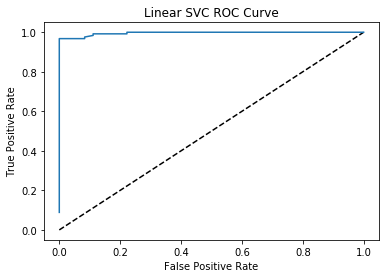

0.0 0.0887096774194
0.0 0.483870967742
0.0 0.5
0.0 0.967741935484
0.0833333333333 0.967741935484
0.0833333333333 0.975806451613
0.111111111111 0.983870967742
0.111111111111 0.991935483871
0.222222222222 0.991935483871
0.222222222222 1.0
0.555555555556 1.0
0.611111111111 1.0
0.694444444444 1.0
1.0 1.0


In [9]:
plot_roc(best1.best_estimator_, X_test1, Y_test1)

## 2. PD vs MSA/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.6s finished


Best parameters set found on development set:

{'classifier__C': 0.0088586679041008226}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.79      0.79      0.79        82
          1       0.54      0.54      0.54        37

avg / total       0.71      0.71      0.71       119


Confusion matrix, without normalization
[[65 17]
 [17 20]]

recall	0.540540540541
precision	0.540540540541
auc	0.666611733685
specificity	0.792682926829
npv	0.792682926829
accuracy	0.714285714286
weighted_sensitivity	0.540540540541
weighted_ppv	0.722785368004
weighted_specificity	0.792682926829
weighted_npv	0.633061331929
weighted_accuracy	0.666611733685
TRAINNG PROBABILITIES
0 0.183475098294
0 0.311336123625
0 0.539566530898
0 0.415729213459
0 0.320528230649
0 0.297062065846
1 0.616700794994
0 0.230658643214
0 0.549751339818
0 0.363877684078


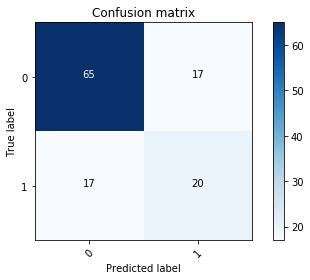

In [10]:
# Get the data
data2 = group_classes(_data, {1:0, 2:1, 3:1})

y2 = data2['GroupID']
X2 = data2.drop(['GroupID'], axis=1)

X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=_test_size, random_state=_random_seed)

best2 = grid_search_optimization(clf, param_grid, X_train2, Y_train2, X_test2, Y_test2, cv=_cv, scoring=_scoring)

In [11]:
scores = cross_validate(best2.best_estimator_, X_train2, Y_train2, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.0190001010895	0.0028473717587
score_time	0.0172985553741	0.00461148180175
test_recall	0.64253968254	0.0576205780548
train_recall	0.640678824721	0.0194700300185
test_precision	0.606017662399	0.0938761585458
train_precision	0.592984456314	0.0197058468297
test_auc	0.69440543449	0.0581626422357
train_auc	0.690752592277	0.0151969798372
test_specificity	0.746271186441	0.0777694235902
train_specificity	0.740826359833	0.0177556899664
test_npv	0.778914349277	0.037921706322
train_npv	0.777886246347	0.0118353729077
test_accuracy	0.707733296006	0.0618557134107
train_accuracy	0.703708324996	0.0152004575714
test_weighted_sensitivity	0.64253968254	0.0576205780548
train_weighted_sensitivity	0.640678824721	0.0194700300185
test_weighted_ppv	0.71985067223	0.0753115869125
train_weighted_ppv	0.712068781193	0.0168897177905
test_weighted_specificity	0.746271186441	0.0777694235902
train_weighted_specificity	0.740826359833	0.0177556899664
test_weighted_npv	0.675791445899	0.0479105296904
train_weight

In [12]:
model = best2.best_estimator_.named_steps['classifier']
feature_names = data2.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.274527589884
Sex	0.0
UPDRS	0.644029334485


             precision    recall  f1-score   support

          0       0.79      0.79      0.79        82
          1       0.54      0.54      0.54        37

avg / total       0.71      0.71      0.71       119

TESTING PROBABILITIES
0 0.415474554843
0 0.0929589207583
1 0.791587811877
0 0.210373758071
1 0.893023341264
0 0.34933806219
0 0.153316088435
1 0.535741759162
0 0.104846159847
1 0.40319995561
0 0.114836134375
0 0.418914390089
1 0.539434137565
0 0.536899684872
0 0.204999701769
1 0.484631163223
1 0.32927421546
0 0.240913977902
1 0.481581803218
1 0.344849510768
1 0.809548610125
1 0.362399519249
0 0.0910805193902
0 0.581730090191
0 0.211663657788
0 0.199946706209
1 0.395290044154
0 0.277786982356
1 0.187493572466
0 0.303413079991
0 0.236634341791
0 0.367387412431
0 0.594427594359
0 0.195656334957
1 0.130633431904
0 0.0501216789107
0 0.25794401283
1 0.6261507552
0 0.374275069877
0 0.429544715657
1 0.223321202873
0 0.117723852884
1 0.573232764952
1 0.112570527821
1 0.195169081031
0

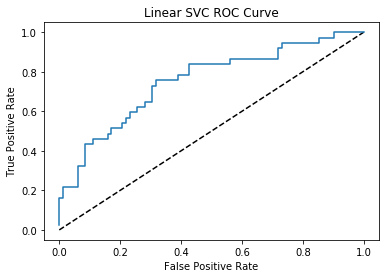

0.0 0.027027027027
0.0 0.162162162162
0.0121951219512 0.162162162162
0.0121951219512 0.216216216216
0.0609756097561 0.216216216216
0.0609756097561 0.324324324324
0.0853658536585 0.324324324324
0.0853658536585 0.432432432432
0.109756097561 0.432432432432
0.109756097561 0.459459459459
0.158536585366 0.459459459459
0.158536585366 0.486486486486
0.170731707317 0.486486486486
0.170731707317 0.513513513514
0.207317073171 0.513513513514
0.207317073171 0.540540540541
0.219512195122 0.540540540541
0.219512195122 0.567567567568
0.231707317073 0.567567567568
0.231707317073 0.594594594595
0.256097560976 0.594594594595
0.256097560976 0.621621621622
0.280487804878 0.621621621622
0.280487804878 0.648648648649
0.30487804878 0.648648648649
0.30487804878 0.702702702703
0.30487804878 0.72972972973
0.317073170732 0.72972972973
0.317073170732 0.756756756757
0.390243902439 0.756756756757
0.390243902439 0.783783783784
0.426829268293 0.783783783784
0.426829268293 0.837837837838
0.560975609756 0.837837837838
0

In [13]:
plot_roc(best2.best_estimator_, X_test2, Y_test2)

## 3. MSA vs PD/PSP

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  85 out of 100 | elapsed:   11.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.2s finished


Best parameters set found on development set:

{'classifier__C': 0.00012742749857031334}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.00      0.00      0.00       107
          1       0.10      1.00      0.18        12

avg / total       0.01      0.10      0.02       119


Confusion matrix, without normalization
[[  0 107]
 [  0  12]]


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



recall	1.0
precision	0.100840336134
auc	0.5
specificity	0.0
npv	nan
accuracy	0.100840336134
weighted_sensitivity	1.0
weighted_ppv	0.5
weighted_specificity	0.0
weighted_npv	nan
weighted_accuracy	0.5
TRAINNG PROBABILITIES
0 0.141030059309
0 0.140763626046
0 0.140724587081
0 0.140916689788
0 0.140943683169
0 0.140921504995
0 0.140603899275
0 0.140802294403
0 0.140768536632
0 0.140976264212
1 0.140236489152
0 0.140841880837
0 0.140430506494
0 0.141030274374
0 0.140972064206
0 0.140223951222
0 0.141218878487
1 0.140745665825
0 0.140981797798
0 0.141058719946
1 0.140765057556
0 0.141106551392
0 0.141155996457
0 0.141205025423
0 0.140010416637
0 0.140603184204
0 0.141388327726
0 0.14124602027
0 0.140818691965
0 0.140758149493
0 0.140900475868
0 0.140956919816
0 0.14098451472
0 0.141155781232
1 0.140489172742
1 0.140324144614
0 0.14105721424
0 0.141004650733
0 0.139882351083
0 0.141063087254
1 0.140603899275
0 0.14096863086
0 0.141286874972
0 0.140606874459
1 0.140879256207
0 0.140837734074
0

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in double_scalars


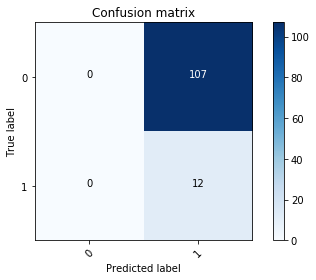

In [14]:
# Get the data
data3 = group_classes(_data, {1:0, 3:0, 2:1})

y3 = data3['GroupID']
X3 = data3.drop(['GroupID'], axis=1)

X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, y3, test_size=_test_size, random_state=_random_seed)

best3 = grid_search_optimization(clf, param_grid, X_train3, Y_train3, X_test3, Y_test3, cv=_cv, scoring=_scoring)

In [15]:
scores = cross_validate(best3.best_estimator_, X_train3, Y_train3, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being 

fit_time	0.0354001045227	0.0123997893456
score_time	0.0246001243591	0.0127380931403
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	1.0	0.0
train_specificity	1.0	0.0
test_npv	0.848451847704	0.00388148934653
train_npv	0.848422984413	0.000975506261926
test_accuracy	0.848451847704	0.00388148934653
train_accuracy	0.848422984413	0.000975506261926
test_weighted_sensitivity	0.0	0.0
train_weighted_sensitivity	0.0	0.0
test_weighted_ppv	nan	nan
train_weighted_ppv	nan	nan
test_weighted_specificity	1.0	0.0
train_weighted_specificity	1.0	0.0
test_weighted_npv	0.5	0.0
train_weighted_npv	0.5	0.0
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars


In [16]:
model = best3.best_estimator_.named_steps['classifier']
feature_names = data3.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.00136449353245
Sex	0.0
UPDRS	0.0295573546698


             precision    recall  f1-score   support

          0       0.00      0.00      0.00       107
          1       0.10      1.00      0.18        12

avg / total       0.01      0.10      0.02       119

TESTING PROBABILITIES
0 0.14082596052
0 0.141255669627
0 0.140535512708
0 0.140976214275
0 0.140095151845
0 0.140815140256
0 0.141041345272
1 0.140695317604
0 0.141316081882
0 0.140853655504
0 0.141169630258
0 0.140866956702
0 0.140679268062
0 0.140796222174
0 0.141146087589
1 0.140578004617
0 0.140981797798
0 0.141125984678
1 0.14071827482
0 0.140901428823
0 0.140273066163
1 0.140898663325
0 0.141308433157
0 0.140625535031
0 0.141144702828
0 0.140939483974
0 0.140932618679
0 0.140871555625
0 0.141033042031
0 0.141037243556
0 0.14108783747
0 0.140846027702
0 0.140654863896
0 0.141096143408
0 0.141385554245
0 0.141318804185
0 0.141006034345
1 0.140478374123
0 0.140904624175
0 0.140875824751
0 0.14107743064
0 0.141103732555
1 0.140659077687
0 0.141222366935
0 0.141028747187
0 

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


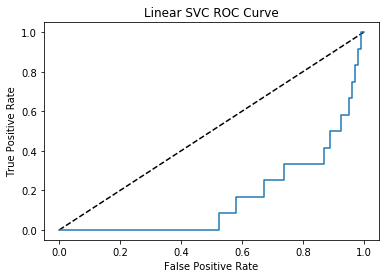

0.0 0.0
0.00934579439252 0.0
0.18691588785 0.0
0.205607476636 0.0
0.523364485981 0.0
0.523364485981 0.0833333333333
0.579439252336 0.0833333333333
0.579439252336 0.166666666667
0.644859813084 0.166666666667
0.663551401869 0.166666666667
0.672897196262 0.166666666667
0.672897196262 0.25
0.738317757009 0.25
0.738317757009 0.333333333333
0.869158878505 0.333333333333
0.869158878505 0.416666666667
0.88785046729 0.416666666667
0.88785046729 0.5
0.92523364486 0.5
0.92523364486 0.583333333333
0.953271028037 0.583333333333
0.953271028037 0.666666666667
0.96261682243 0.666666666667
0.96261682243 0.75
0.971962616822 0.75
0.971962616822 0.833333333333
0.981308411215 0.833333333333
0.981308411215 0.916666666667
0.990654205607 0.916666666667
0.990654205607 1.0
1.0 1.0


In [17]:
plot_roc(best3.best_estimator_, X_test3, Y_test3)

## 4. PSP vs PD/MSA

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.4s finished
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'classifier__C': 0.00012742749857031334}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.79      1.00      0.88        94
          1       0.00      0.00      0.00        25

avg / total       0.62      0.79      0.70       119


Confusion matrix, without normalization
[[94  0]
 [25  0]]

recall	0.0
precision	0.0
auc	0.5
specificity	1.0
npv	0.789915966387
accuracy	0.789915966387
weighted_sensitivity	0.0
weighted_ppv	nan
weighted_specificity	1.0
weighted_npv	0.5
weighted_accuracy	0.5
TRAINNG PROBABILITIES
0 0.233169078892
0 0.233103147638
0 0.232118491871
0 0.232161177351
0 0.232556329094
0 0.232743797364
1 0.232096337629
0 0.233468153961
0 0.231950265465
0 0.232254077721
0 0.232066049949
0 0.232468022265
1 0.23235861928
0 0.233045070131
1 0.232994532365
0 0.2317663939

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars


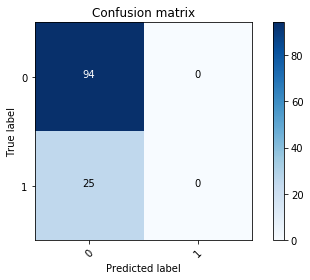

In [18]:
# Get the data
data4 = group_classes(_data, {1:0, 2:0, 3:1})

y4 = data4['GroupID']
X4 = data4.drop(['GroupID'], axis=1)

X_train4, X_test4, Y_train4, Y_test4 = train_test_split(X4, y4, test_size=_test_size, random_state=_random_seed)

best4 = grid_search_optimization(clf, param_grid, X_train4, Y_train4, X_test4, Y_test4, cv=_cv, scoring=_scoring)

In [19]:
scores = cross_validate(best4.best_estimator_, X_train4, Y_train4, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being 

fit_time	0.0141856193542	0.00262994251305
score_time	0.0156032085419	0.00265121176346
test_recall	0.0	0.0
train_recall	0.0	0.0
test_precision	0.0	0.0
train_precision	0.0	0.0
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	1.0	0.0
train_specificity	1.0	0.0
test_npv	0.781065229563	0.00321074450158
train_npv	0.781053407937	0.000794904701927
test_accuracy	0.781065229563	0.00321074450158
train_accuracy	0.781053407937	0.000794904701927
test_weighted_sensitivity	0.0	0.0
train_weighted_sensitivity	0.0	0.0
test_weighted_ppv	nan	nan
train_weighted_ppv	nan	nan
test_weighted_specificity	1.0	0.0
train_weighted_specificity	1.0	0.0
test_weighted_npv	0.5	0.0
train_weighted_npv	0.5	0.0
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


In [20]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.0196779230757
Sex	0.0
UPDRS	0.0120225755777


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.79      1.00      0.88        94
          1       0.00      0.00      0.00        25

avg / total       0.62      0.79      0.70       119

TESTING PROBABILITIES
0 0.232412894589
0 0.233447803699
1 0.231295024868
0 0.23312231388
1 0.231613234509
0 0.232775517698
0 0.233385980647
0 0.232216947741
0 0.233127419603
1 0.232395606437
0 0.23341454518
0 0.232283230188
1 0.232244310571
0 0.231933001328
0 0.232690463179
0 0.232776203205
1 0.232424086505
0 0.232507703242
0 0.232402070544
1 0.232561008233
1 0.231891554131
0 0.232475958083
0 0.233327854111
0 0.232197674873
0 0.232647918896
0 0.233297454546
1 0.232216263382
0 0.232990006053
1 0.233130265249
0 0.232389509937
0 0.232639978988
0 0.232595602587
0 0.232058015635
0 0.232895319918
1 0.232649757736
0 0.234083362688
0 0.232734434026
0 0.23240023307
0 0.232398496109
0 0.232208333748
1 0.232755000383
0 0.233564527604
0 0.232144219259
1 0.23329460748
1 0.23308513759
0 0

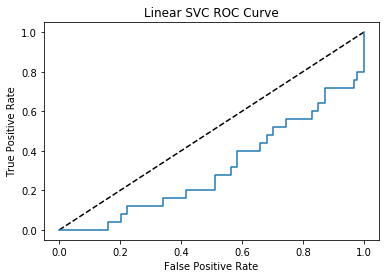

0.0 0.0
0.0106382978723 0.0
0.159574468085 0.0
0.159574468085 0.04
0.202127659574 0.04
0.202127659574 0.08
0.223404255319 0.08
0.223404255319 0.12
0.340425531915 0.12
0.340425531915 0.16
0.414893617021 0.16
0.414893617021 0.2
0.468085106383 0.2
0.489361702128 0.2
0.510638297872 0.2
0.510638297872 0.28
0.563829787234 0.28
0.563829787234 0.32
0.585106382979 0.32
0.585106382979 0.4
0.659574468085 0.4
0.659574468085 0.44
0.68085106383 0.44
0.68085106383 0.48
0.702127659574 0.48
0.702127659574 0.52
0.744680851064 0.52
0.744680851064 0.56
0.829787234043 0.56
0.829787234043 0.6
0.851063829787 0.6
0.851063829787 0.64
0.872340425532 0.64
0.872340425532 0.72
0.968085106383 0.72
0.968085106383 0.76
0.978723404255 0.76
0.978723404255 0.8
1.0 0.8
1.0 1.0


In [21]:
plot_roc(best4.best_estimator_, X_test4, Y_test4)

## 5. PSP (positive) vs MSA (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.1s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.31      0.38      0.34        13
          1       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[ 5  8]
 [11 19]]

recall	0.633333333333
precision	0.703703703704
auc	0.508974358974
specificity	0.384615384615
npv	0.3125
accuracy	0.558139534884
weighted_sensitivity	0.633333333333
weighted_ppv	0.507186858316
weighted_specificity	0.384615384615
weighted_npv	0.511945392491
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
1 0.477723860232
0 0.56266343833
0 0.116301162406
1 0.885525074869
1 0.328028137849
1 0.829308878579
1 0.826700804223
0 0.445984726204
1 0.890852667349
1 0.672252352755
1 0.896881

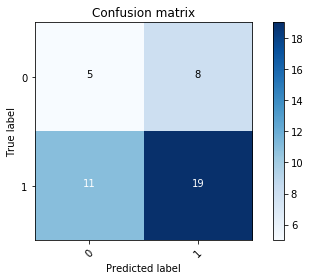

In [22]:
# Get the data
data5 = group_classes(_data, {2:0, 3:1})

y5 = data5['GroupID']
X5 = data5.drop(['GroupID'], axis=1)

X_train5, X_test5, Y_train5, Y_test5 = train_test_split(X5, y5, test_size=_test_size, random_state=_random_seed)

best5 = grid_search_optimization(clf, param_grid, X_train5, Y_train5, X_test5, Y_test5, cv=_cv, scoring=_scoring)

In [23]:
scores = cross_validate(best5.best_estimator_, X_train5, Y_train5, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00479969978333	0.000600648330903
score_time	0.0116002082825	0.00168483397088
test_recall	0.667894736842	0.105215778811
train_recall	0.676803797468	0.0228873396369
test_precision	0.781764507422	0.0957109683723
train_precision	0.782399129074	0.0346019059782
test_auc	0.699661654135	0.0901241911717
train_auc	0.706290369912	0.0301353128205
test_specificity	0.731428571429	0.124343172269
train_specificity	0.735776942356	0.0491779203385
test_npv	0.616666666667	0.104436724759
train_npv	0.619871740064	0.0277935226111
test_accuracy	0.693868092692	0.0887190398129
train_accuracy	0.701463591114	0.0277940644804
test_weighted_sensitivity	0.667894736842	0.105215778811
train_weighted_sensitivity	0.676803797468	0.0228873396369
test_weighted_ppv	0.723503060295	0.116868020371
train_weighted_ppv	0.720987818774	0.042248042129
test_weighted_specificity	0.731428571429	0.124343172269
train_weighted_specificity	0.735776942356	0.0491779203385
test_weighted_npv	0.689550608599	0.0890769851567
train_weigh

In [24]:
model = best4.best_estimator_.named_steps['classifier']
feature_names = data4.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	0.0196779230757
Sex	0.0
UPDRS	0.0120225755777


             precision    recall  f1-score   support

          0       0.31      0.38      0.34        13
          1       0.70      0.63      0.67        30

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
0 0.359156638281
1 0.805906207735
1 0.349601348284
0 0.691658976881
0 0.610047446193
1 0.63065255127
0 0.518113434861
0 0.637180122062
1 0.490693729337
1 0.662573644826
1 0.545929694997
1 0.244296475191
1 0.476520642522
0 0.837213358234
0 0.61724254655
1 0.688569828165
1 0.603581449536
1 0.73763027016
1 0.760239457691
1 0.386427624187
0 0.598001696856
1 0.646550775223
1 0.421716388941
0 0.730173429827
1 0.871117425288
1 0.65825868997
1 0.786374655381
1 0.440790091249
1 0.793301968464
1 0.71218517446
1 0.341270204435
0 0.226126703975
1 0.643973535766
0 0.341165902106
1 0.421602445287
0 0.304245765447
1 0.808904067516
1 0.569660273641
1 0.617485897754
1 0.637260447549
0 0.68060883643
1 0.645506699298
1 0.413288824711


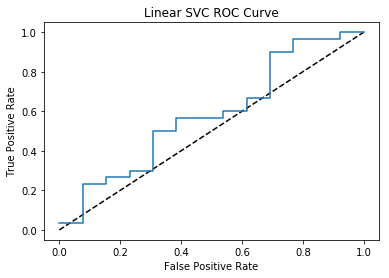

0.0 0.0333333333333
0.0769230769231 0.0333333333333
0.0769230769231 0.233333333333
0.153846153846 0.233333333333
0.153846153846 0.266666666667
0.230769230769 0.266666666667
0.230769230769 0.3
0.307692307692 0.3
0.307692307692 0.5
0.384615384615 0.5
0.384615384615 0.566666666667
0.538461538462 0.566666666667
0.538461538462 0.6
0.615384615385 0.6
0.615384615385 0.666666666667
0.692307692308 0.666666666667
0.692307692308 0.9
0.769230769231 0.9
0.769230769231 0.966666666667
0.923076923077 0.966666666667
0.923076923077 1.0
1.0 1.0


In [25]:
plot_roc(best5.best_estimator_, X_test5, Y_test5)

## 6. MSA (positive) vs PSP (negative)

# Tuning hyper-parameters for f1_micro

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.5s finished


Best parameters set found on development set:

{'classifier__C': 0.048329302385717518}

Detailed classification report (holdout):

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.70      0.63      0.67        30
          1       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43


Confusion matrix, without normalization
[[19 11]
 [ 8  5]]

recall	0.384615384615
precision	0.3125
auc	0.508974358974
specificity	0.633333333333
npv	0.703703703704
accuracy	0.558139534884
weighted_sensitivity	0.384615384615
weighted_ppv	0.511945392491
weighted_specificity	0.633333333333
weighted_npv	0.507186858316
weighted_accuracy	0.508974358974
TRAINNG PROBABILITIES
0 0.518139863722
1 0.424927290242
1 0.901553415667
0 0.0923825294618
0 0.686703055933
0 0.145502329965
0 0.147998472959
1 0.553431779754
0 0.0876701357859
0 0.30561707039
0 0.0822

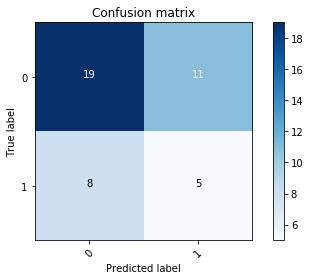

In [26]:
# Get the data
data6 = group_classes(_data, {2:1, 3:0})

y6 = data6['GroupID']
X6 = data6.drop(['GroupID'], axis=1)

X_train6, X_test6, Y_train6, Y_test6 = train_test_split(X6, y6, test_size=_test_size, random_state=_random_seed)

best6 = grid_search_optimization(clf, param_grid, X_train6, Y_train6, X_test6, Y_test6, cv=_cv, scoring=_scoring)

In [27]:
scores = cross_validate(best4.best_estimator_, X_train6, Y_train6, cv=_cv, return_train_score=True, scoring=_scoring_list)
for score in scores:
    print("%s\t%s\t%s" %(score, np.mean(scores[score]), np.std(scores[score])))

fit_time	0.00400080680847	0.000631957785219
score_time	0.0114015579224	0.00224470950464
test_recall	0.4	0.489897948557
train_recall	0.4	0.489897948557
test_precision	0.170562770563	0.208900364004
train_precision	0.166174641795	0.203521920226
test_auc	0.5	0.0
train_auc	0.5	0.0
test_specificity	0.6	0.489897948557
train_specificity	0.6	0.489897948557
test_npv	nan	nan
train_npv	nan	nan
test_accuracy	0.523503947033	0.079291203616
train_accuracy	0.51470405356	0.0810524867754
test_weighted_sensitivity	0.4	0.489897948557
train_weighted_sensitivity	0.4	0.489897948557
test_weighted_ppv	nan	nan
train_weighted_ppv	nan	nan
test_weighted_specificity	0.6	0.489897948557
train_weighted_specificity	0.6	0.489897948557
test_weighted_npv	nan	nan
train_weighted_npv	nan	nan
test_weighted_accuracy	0.5	0.0
train_weighted_accuracy	0.5	0.0


C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in longlong_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jtbricker\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\j

In [28]:
model = best6.best_estimator_.named_steps['classifier']
feature_names = data6.columns.tolist()[1:]
#plot_coefficients(model, feature_names)
print_feature_importance(feature_names, model.coef_[0])

Age	-0.591393122754
Sex	-0.18840053372
UPDRS	0.661648238171


             precision    recall  f1-score   support

          0       0.70      0.63      0.67        30
          1       0.31      0.38      0.34        13

avg / total       0.59      0.56      0.57        43

TESTING PROBABILITIES
1 0.650932475522
0 0.168346083495
0 0.66124331618
1 0.28493197701
1 0.375028542593
0 0.355324248482
1 0.473464351261
1 0.349139550776
0 0.5
0 0.316350013278
0 0.443050244761
0 0.77217644408
0 0.519617563085
1 0.137840183375
1 0.368012029188
0 0.288301025642
0 0.381513686514
0 0.237402492269
0 0.21416005974
0 0.621581193873
1 0.387717679125
0 0.336070412594
0 0.580666337993
1 0.244775428549
0 0.105627687349
0 0.320935061045
0 0.187804699574
0 0.559054055587
0 0.180507091158
0 0.263454842859
0 0.670957812503
1 0.791351566532
0 0.342687287689
1 0.671182355712
0 0.580707598722
1 0.708404255557
0 0.1653512731
0 0.417115655806
0 0.367653137297
0 0.348539416799
1 0.297132503924
0 0.340949881329
0 0.590329820763


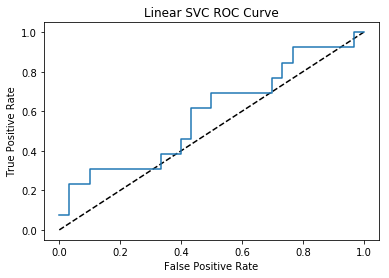

0.0 0.0769230769231
0.0333333333333 0.0769230769231
0.0333333333333 0.230769230769
0.1 0.230769230769
0.1 0.307692307692
0.333333333333 0.307692307692
0.333333333333 0.384615384615
0.4 0.384615384615
0.4 0.461538461538
0.433333333333 0.461538461538
0.433333333333 0.615384615385
0.5 0.615384615385
0.5 0.692307692308
0.7 0.692307692308
0.7 0.769230769231
0.733333333333 0.769230769231
0.733333333333 0.846153846154
0.766666666667 0.846153846154
0.766666666667 0.923076923077
0.966666666667 0.923076923077
0.966666666667 1.0
1.0 1.0


In [29]:
plot_roc(best6.best_estimator_, X_test6, Y_test6)

In [30]:
print("Control (0) vs All Parkinsons(1)")
print("TRAIN/VALIDATION")
print(Y_train1.value_counts())
print("TEST")
print(Y_test1.value_counts())
print()
print("=====================================")
print()
print("2. PD(0) vs MSA/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train2.value_counts())
print("TEST")
print(Y_test2.value_counts())
print()
print("=====================================")
print()
print("MSA (0) vs PD/PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train3.value_counts())
print("TEST")
print(Y_test3.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA/PD (1)")
print("TRAIN/VALIDATION")
print(Y_train4.value_counts())
print("TEST")
print(Y_test4.value_counts())
print("=====================================")
print()
print("MSA (0) vs PSP(1)")
print("TRAIN/VALIDATION")
print(Y_train5.value_counts())
print("TEST")
print(Y_test5.value_counts())
print()
print("=====================================")
print()
print("PSP (0) vs MSA(1)")
print("TRAIN/VALIDATION")
print(Y_train6.value_counts())
print("TEST")
print(Y_test6.value_counts())
print()


Control (0) vs All Parkinsons(1)
TRAIN/VALIDATION
1    470
0    166
Name: GroupID, dtype: int64
TEST
1    124
0     36
Name: GroupID, dtype: int64


2. PD(0) vs MSA/PSP(1)
TRAIN/VALIDATION
0    299
1    176
Name: GroupID, dtype: int64
TEST
0    82
1    37
Name: GroupID, dtype: int64


MSA (0) vs PD/PSP(1)
TRAIN/VALIDATION
0    403
1     72
Name: GroupID, dtype: int64
TEST
0    107
1     12
Name: GroupID, dtype: int64


PSP (0) vs MSA/PD (1)
TRAIN/VALIDATION
0    371
1    104
Name: GroupID, dtype: int64
TEST
0    94
1    25
Name: GroupID, dtype: int64

MSA (0) vs PSP(1)
TRAIN/VALIDATION
1    99
0    71
Name: GroupID, dtype: int64
TEST
1    30
0    13
Name: GroupID, dtype: int64


PSP (0) vs MSA(1)
TRAIN/VALIDATION
0    99
1    71
Name: GroupID, dtype: int64
TEST
0    30
1    13
Name: GroupID, dtype: int64



In [31]:
import pickle
mod_name = 'updrs-plus'
pickle.dump(best1, open('./models/%s/park_v_control.pkl' %mod_name, 'wb'))
pickle.dump(best2, open('./models/%s/pd_v_atypical.pkl' %mod_name, 'wb'))
pickle.dump(best3, open('./models/%s/msa_v_pd_psp.pkl' %mod_name, 'wb'))
pickle.dump(best4, open('./models/%s/psp_v_pd_msa.pkl' %mod_name, 'wb'))
pickle.dump(best5, open('./models/%s/psp_v_msa.pkl' %mod_name, 'wb'))